In [1]:
# hide
# default_exp datasets

from nbdev.showdoc import *

# Secondary Baseline
> Murdock, B. B., & Okada, R. (1970). Interresponse times in single-trial free recall. Journal of Experimental Psychology, 86(2), 263.

## The Dataset

Authors investigated interresponse times in single-trial free recall. Each of 72 undergraduates was given 20 test lists with 20-word lists visually presented at either 60 or 120 words/min. The format of the data in these files is as follows:  

Row 1: subject/trial information  
Row 2: serial position as a function of output position.  
Row 3: inter-response time as a function of output position  

The code 88 means that the subject made an extra-list intrusion.

In [2]:
# export
# hide
import scipy.io as sio
import numpy as np
import pandas as pd
from psifr import fr

def prepare_okadata(path):
    """
    Prepares data formatted like `data/MurdData_clean.mat` for fitting.

    Loads data from `path` with same format as `data/MurdData_clean.mat` and 
    returns a selected dataset as an array of unique recall trials and a 
    dataframe of unique study and recall events organized according to `psifr`
    specifications.  

    **Arguments**:  
    - path: source of data file  
    - dataset_index: index of the dataset to be extracted from the file

    **Returns**:
    - trials: int64-array where rows identify a unique trial of responses and 
        columns corresponds to a unique recall index.  
    - merged: as a long format table where each row describes one study or 
        recall event.  
    - list_length: length of lists studied in the considered dataset
    """
    
    with open(path) as f:
        oka_data = f.read()

    counter = 0
    trials = []
    subjects = []
    list_length = 20

    for line in oka_data.split('\n'):

        if not line:
            continue

        # build subjects array
        if counter == 0:
            subjects.append(int(line.strip().split('    ')[1]))

        # build trials array
        if counter == 1:

            trial = [int(each) for each in line.strip().split('    ')]
            trial = [each for each in trial if each <= 20]
            already = []
            for each in trial:
                if each not in already:
                    already.append(each)
            trial = already
            
            while len(trial) < 13:
                trial.append(0)

            trials.append(trial)

        # keep track of which row we are on for the given trial
        counter += 1
        if counter == 3:
            counter = 0

    trials = np.array(trials).astype('int64')
    
    data = []
    for trial_index, trial in enumerate(trials):

        # every time the subject changes, reset list_index
        if not data or data[-1][0] != subjects[trial_index]:
            list_index = 0
        list_index += 1

        # add study events
        for i in range(list_length):
            data += [[subjects[trial_index], 
                      list_index, 'study', i+1, i+1]]

        # add recall events
        for recall_index, recall_event in enumerate(trial):
            if recall_event != 0:
                data += [[subjects[trial_index], list_index, 
                          'recall', recall_index+1, recall_event]]

    data = pd.DataFrame(data, columns=[
        'subject', 'list', 'trial_type', 'position', 'item'])
    merged = fr.merge_free_recall(data)
    return trials, merged, list_length

In [3]:
murd_trials, murd_events, murd_length = prepare_okadata('../../data/mo1970.txt')

In [4]:
murd_events.head()

,subject,list,item,input,output,study,recall,repeat,intrusion
0,1,1,1,1,NaN,True,False,0,False
1,1,1,2,2,NaN,True,False,0,False
2,1,1,3,3,NaN,True,False,0,False
3,1,1,4,4,NaN,True,False,0,False
4,1,1,5,5,NaN,True,False,0,False


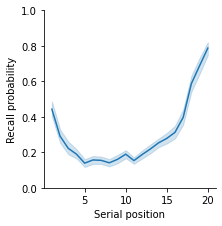

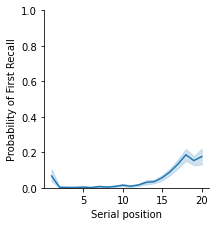

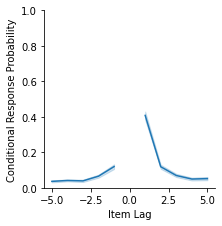

In [5]:
from instance_cmr.datasets import visualize_aggregate

visualize_aggregate(murd_events, 'subject > -1')

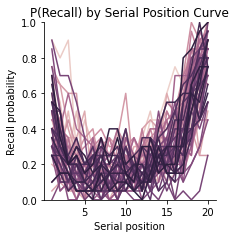

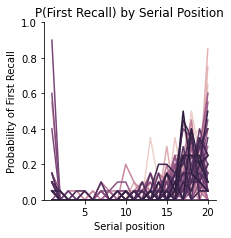

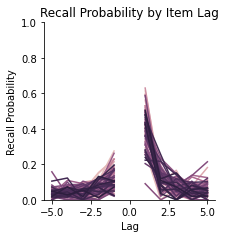

In [6]:
from instance_cmr.datasets import visualize_individuals

visualize_individuals(murd_events, 'subject > -1')